# Préparation du dataset

## Import du dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from os import listdir

path = "D:/ML_Datasets/Weather/dataset/"
list_photos = [file for file in listdir(path)]
print(len(list_photos))

400


## Création des labels des photos à partir du nom des images

In [2]:
from sklearn import preprocessing

list_labels = ["cloudy", "rain", "shine", "sunrise"]
label_name = "no_name "

def photo_class(photo) :
    for label in list_labels :
        if label in photo : 
            return label
    return label_name
    
data = pd.DataFrame()
data["image_path"] = list_photos
data["label_name"] = data["image_path"].apply(lambda x : photo_class(x))
le = preprocessing.LabelEncoder()
data["label"] = le.fit_transform(data["label_name"])
data

,image_path,label_name,label
0,cloudy1.jpg,cloudy,0
1,cloudy10.jpg,cloudy,0
2,cloudy100.jpg,cloudy,0
3,cloudy11.jpg,cloudy,0
4,cloudy12.jpg,cloudy,0
...,...,...,...
395,sunrise95.jpg,sunrise,3
396,sunrise96.jpg,sunrise,3
397,sunrise97.jpg,sunrise,3
398,sunrise98.jpg,sunrise,3


In [3]:
data.groupby("label").count()

,image_path,label_name
label,,
0,100,100
1,100,100
2,100,100
3,100,100


## Affichage d'exemples d'images par label

cloudy


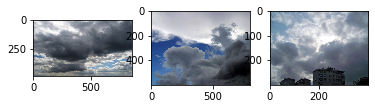

rain


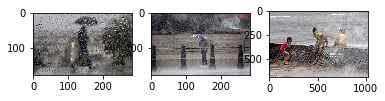

shine


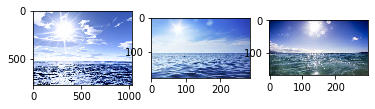

sunrise


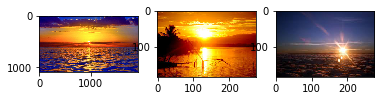

In [4]:
from matplotlib.image import imread

def list_fct(name) :
    list_image_name = [list_photos[i] for i in range(len(data)) if data["label_name"][i]==name]
    return list_image_name

list_cloudy=[list_photos[i] for i in range(len(data)) if data["label_name"][i]=="cloudy"]
list_rain=[list_photos[i] for i in range(len(data)) if data["label_name"][i]=="rain"]
list_shine=[list_photos[i] for i in range(len(data)) if data["label_name"][i]=="shine"]
list_sunrise=[list_photos[i] for i in range(len(data)) if data["label_name"][i]=="sunrise"]

for name in list_labels :
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_fct(name)[i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

## Détermination et affichage des descripteurs SIFT

* L'image contient 319 descripteurs
* Chaque descripteur est un vecteur de longueur 128

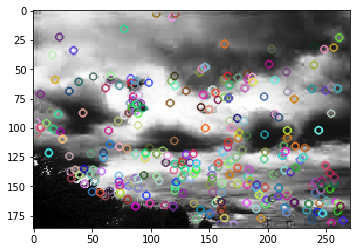

Descripteurs :  (319, 128)

[[ 21.   2.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...  21.  13.  12.]
 [  1.   1.   0. ...  13.   1.   3.]
 ...
 [ 46.  22.   0. ...   0.   0.   0.]
 [ 26. 140.   5. ...   1.   0.   0.]
 [ 49.  33.   4. ...  59.   2.   1.]]


In [5]:
import cv2

sift = cv2.xfeatures2d.SIFT_create()
image = cv2.imread(path+list_photos[1],0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)


# Pré-traitement des images via SIFT

## Créations des descripteurs de chaque image
* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [6]:
# identification of key points and associated descriptors
import time, cv2
sift_keypoints = []
temps1=time.time()
sift = cv2.xfeatures2d.SIFT_create(500)

for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path+list_photos[image_num],0) # convert in gray
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300

Nombre de descripteurs :  (150147, 128)
temps de traitement SIFT descriptor :            99.16 secondes


## Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [7]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  387
Création de 387 clusters de descripteurs ...
temps de traitement kmeans :            55.64 secondes


## Création des features des images
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [18]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
300
temps de création histogrammes :             6.47 secondes


## Réductions de dimension

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [37]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (400, 387)
Dimensions dataset après réduction PCA :  (400, 252)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [39]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label_name"]
print(df_tsne.shape)


(400, 3)


## Analyse visuelle : affichage T-SNE selon catégories d'images
* Les catégories "cloudy" et "rain" sont partiellement séparées

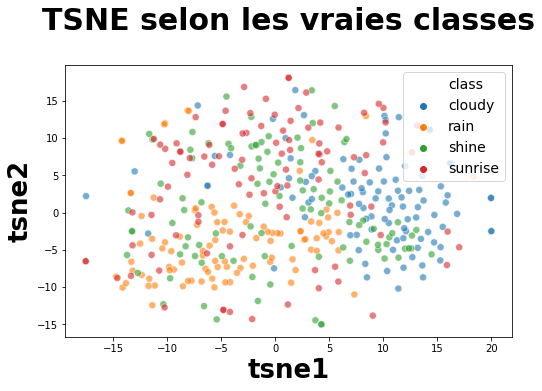

In [40]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=4), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()


## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [35]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=4, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


(400, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters
* Le score ARI de 0.15 reste faible

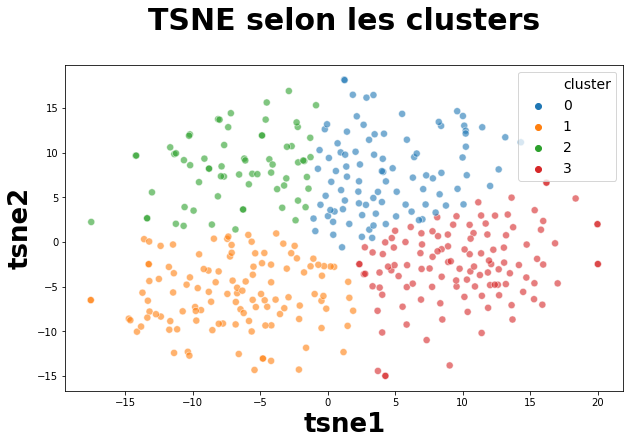

ARI :  0.14512016895669488


In [36]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=4), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### Analyse par classes
* La matrice de confusion doit être transformée pour mettre avoir en colonne le même ordre des catégories supposées qu'en ligne
* Cette transformation atteint ses limites pour les 2 catégories "shine" et "sunshine" qui sont peu séparées (donc elle a été réalisée manuellement au lieu d'utiliser la fonction "argmax")

In [23]:
df_tsne.groupby("cluster").count()["class"]

cluster
0     96
1    118
2     67
3    119
Name: class, dtype: int64

In [30]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[32  2  7 59]
 [ 3 68  9 20]
 [24 27 21 28]
 [37 21 30 12]]


In [31]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    # corresp = np.argmax(conf_mat, axis=0)
    corresp = [3, 1, 2, 0]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [3, 1, 2, 0]
[[59  2  7 32]
 [20 68  9  3]
 [28 27 21 24]
 [12 21 30 37]]

              precision    recall  f1-score   support

           0       0.50      0.59      0.54       100
           1       0.58      0.68      0.62       100
           2       0.31      0.21      0.25       100
           3       0.39      0.37      0.38       100

    accuracy                           0.46       400
   macro avg       0.44      0.46      0.45       400
weighted avg       0.44      0.46      0.45       400



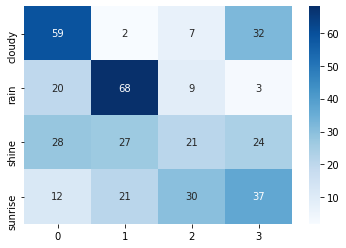

In [32]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")